In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class NaturalGasPriceAnalyzer:
    def __init__(self):
        self.data = None
        self.model = None
        self.seasonal_pattern = None
        self.trend_model = None
        
    def load_data(self, data_string):
        """Load and preprocess the natural gas price data"""
        # Parse the provided data
        lines = data_string.strip().split('\n')[1:]  # Skip header
        dates = []
        prices = []
        
        for line in lines:
            if line.strip():
                date_str, price_str = line.split('\t')
                # Convert scientific notation to float
                price = float(price_str)
                # Parse date
                date = datetime.strptime(date_str, '%m/%d/%Y')
                dates.append(date)
                prices.append(price)
        
        self.data = pd.DataFrame({
            'date': dates,
            'price': prices,
            'month': [d.month for d in dates],
            'year': [d.year for d in dates]
        })
        
        # Convert dates to numerical values for modeling
        self.data['days_since_start'] = (self.data['date'] - self.data['date'].min()).dt.days
        
        print(f"Loaded {len(self.data)} data points")
        print(f"Date range: {self.data['date'].min()} to {self.data['date'].max()}")
        
    def analyze_seasonal_patterns(self):
        """Analyze seasonal trends in the data"""
        # Calculate monthly averages
        monthly_avg = self.data.groupby('month')['price'].mean()
        self.seasonal_pattern = monthly_avg
        
        print("\n=== Seasonal Analysis ===")
        print("Monthly average prices:")
        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        for i, month in enumerate(months, 1):
            if i in monthly_avg.index:
                print(f"{month}: ${monthly_avg[i]:.2f}")
        
        # Identify high and low seasons
        high_season = monthly_avg.idxmax()
        low_season = monthly_avg.idxmin()
        print(f"\nHigh season: {months[high_season-1]} (${monthly_avg[high_season]:.2f})")
        print(f"Low season: {months[low_season-1]} (${monthly_avg[low_season]:.2f})")
        
        return monthly_avg
    
    def build_prediction_model(self):
        """Build a model that combines trend and seasonal components"""
        # Polynomial regression for trend
        X = self.data['days_since_start'].values.reshape(-1, 1)
        y = self.data['price'].values
        
        # Use polynomial regression to capture non-linear trends
        self.trend_model = Pipeline([
            ('poly', PolynomialFeatures(degree=3)),
            ('linear', LinearRegression())
        ])
        self.trend_model.fit(X, y)
        
        # Calculate seasonal adjustments
        self.calculate_seasonal_adjustments()
        
    def calculate_seasonal_adjustments(self):
        """Calculate seasonal adjustments from historical data"""
        # Get trend predictions
        trend_predictions = self.trend_model.predict(
            self.data['days_since_start'].values.reshape(-1, 1)
        )
        
        # Calculate residuals (actual - trend)
        residuals = self.data['price'] - trend_predictions
        
        # Average residuals by month to get seasonal pattern
        seasonal_adjustments = self.data.groupby('month').apply(
            lambda x: x['price'].mean() - trend_predictions[x.index].mean()
        )
        self.seasonal_adjustments = seasonal_adjustments
    
    def estimate_price(self, target_date):
        """Estimate price for any given date"""
        if self.trend_model is None:
            self.build_prediction_model()
        
        # Convert target date to days since start
        start_date = self.data['date'].min()
        days_since_start = (target_date - start_date).days
        
        # Get trend prediction
        trend_pred = self.trend_model.predict([[days_since_start]])[0]
        
        # Add seasonal adjustment
        month = target_date.month
        seasonal_adj = self.seasonal_adjustments.get(month, 0)
        
        # Final price estimate
        estimated_price = trend_pred + seasonal_adj
        
        return max(0, estimated_price)  # Ensure non-negative price
    
    def extrapolate_future_prices(self, months=12):
        """Extrapolate prices for the next year"""
        last_date = self.data['date'].max()
        future_dates = []
        future_prices = []
        
        for i in range(1, months + 1):
            future_date = last_date + timedelta(days=30 * i)
            price = self.estimate_price(future_date)
            future_dates.append(future_date)
            future_prices.append(price)
        
        return pd.DataFrame({
            'date': future_dates,
            'price': future_prices,
            'type': 'predicted'
        })
    
    def visualize_analysis(self):
        """Create comprehensive visualization of the analysis"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot 1: Historical prices with trend
        ax1.plot(self.data['date'], self.data['price'], 'bo-', 
                label='Historical Prices', linewidth=2, markersize=4)
        
        # Add trend line
        trend_predictions = self.trend_model.predict(
            self.data['days_since_start'].values.reshape(-1, 1)
        )
        ax1.plot(self.data['date'], trend_predictions, 'r-', 
                label='Trend Line', linewidth=2, alpha=0.7)
        
        ax1.set_title('Natural Gas Prices: Historical Data & Trend')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Price ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Seasonal pattern
        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        monthly_avg = self.analyze_seasonal_patterns()
        
        ax2.bar(range(1, 13), [monthly_avg.get(i, 0) for i in range(1, 13)])
        ax2.set_title('Seasonal Price Pattern (Monthly Averages)')
        ax2.set_xlabel('Month')
        ax2.set_ylabel('Average Price ($)')
        ax2.set_xticks(range(1, 13))
        ax2.set_xticklabels(months, rotation=45)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Future extrapolation
        future_data = self.extrapolate_future_prices(12)
        
        ax3.plot(self.data['date'], self.data['price'], 'bo-', 
                label='Historical', linewidth=2)
        ax3.plot(future_data['date'], future_data['price'], 'ro--', 
                label='Predicted', linewidth=2)
        ax3.axvline(x=self.data['date'].max(), color='green', linestyle='--', 
                   label='Prediction Start')
        ax3.set_title('Price Forecast: Next 12 Months')
        ax3.set_xlabel('Date')
        ax3.set_ylabel('Price ($)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Price distribution
        ax4.hist(self.data['price'], bins=15, alpha=0.7, edgecolor='black')
        ax4.axvline(self.data['price'].mean(), color='red', linestyle='--', 
                   label=f'Mean: ${self.data["price"].mean():.2f}')
        ax4.set_title('Price Distribution')
        ax4.set_xlabel('Price ($)')
        ax4.set_ylabel('Frequency')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print statistical summary
        self.print_statistical_summary()
    
    def print_statistical_summary(self):
        """Print statistical summary of the data"""
        print("\n=== Statistical Summary ===")
        print(f"Mean price: ${self.data['price'].mean():.2f}")
        print(f"Median price: ${self.data['price'].median():.2f}")
        print(f"Standard deviation: ${self.data['price'].std():.2f}")
        print(f"Minimum price: ${self.data['price'].min():.2f}")
        print(f"Maximum price: ${self.data['price'].max():.2f}")
        print(f"Price range: ${self.data['price'].max() - self.data['price'].min():.2f}")
        
        # Price volatility (annualized)
        returns = self.data['price'].pct_change().dropna()
        volatility = returns.std() * np.sqrt(12)  # Annualized
        print(f"Annualized volatility: {volatility:.2%}")


Loaded 48 data points
Date range: 2020-10-31 00:00:00 to 2024-09-30 00:00:00

=== Seasonal Analysis ===
Monthly average prices:
Jan: $11.78
Feb: $11.70
Mar: $11.78
Apr: $11.18
May: $10.79
Jun: $10.70
Jul: $10.90
Aug: $10.82
Sep: $11.07
Oct: $10.75
Nov: $11.32
Dec: $11.70

High season: Jan ($11.78)
Low season: Jun ($10.70)

=== Price Estimation Examples ===
2023-06-15: $11.12
2024-12-31: $12.11
2025-06-30: $10.22

=== Seasonal Analysis ===
Monthly average prices:
Jan: $11.78
Feb: $11.70
Mar: $11.78
Apr: $11.18
May: $10.79
Jun: $10.70
Jul: $10.90
Aug: $10.82
Sep: $11.07
Oct: $10.75
Nov: $11.32
Dec: $11.70

High season: Jan ($11.78)
Low season: Jun ($10.70)


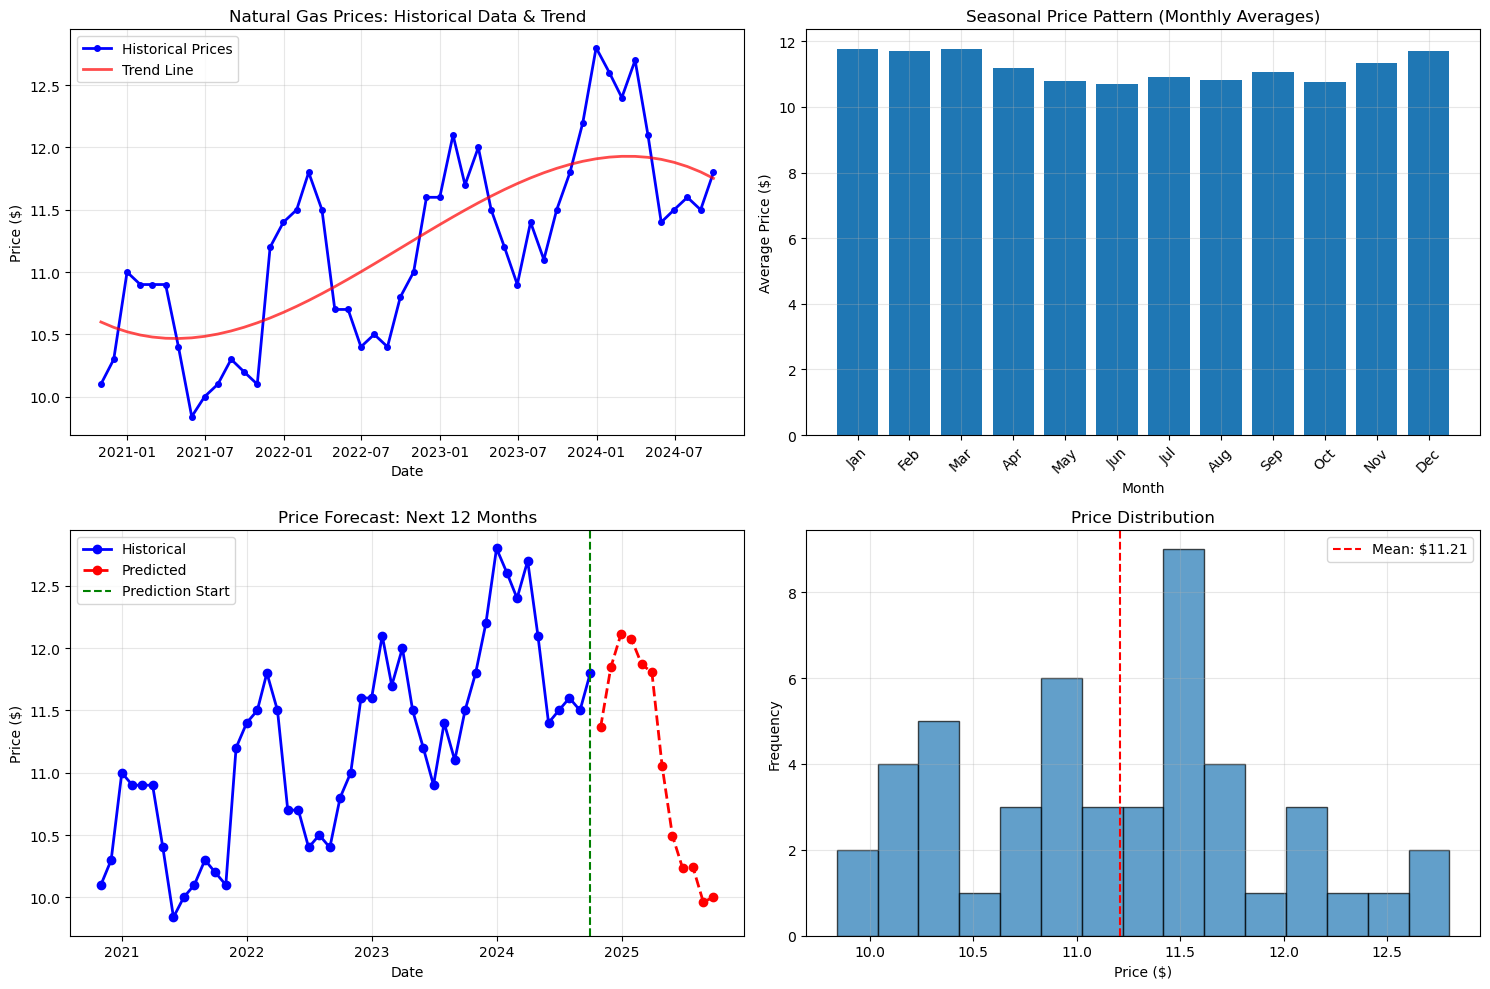


=== Statistical Summary ===
Mean price: $11.21
Median price: $11.30
Standard deviation: $0.76
Minimum price: $9.84
Maximum price: $12.80
Price range: $2.96
Annualized volatility: 12.21%

=== 12-Month Price Forecast ===
2024-10-30: $11.36
2024-11-29: $11.85
2024-12-29: $12.12
2025-01-28: $12.07
2025-02-27: $11.87
2025-03-29: $11.80
2025-04-28: $11.05
2025-05-28: $10.50
2025-06-27: $10.23
2025-07-27: $10.24
2025-08-26: $9.96
2025-09-25: $10.00


In [2]:

def main():
    # Provided data
    data_string = """Dates	Prices
10/31/2020	1.01E+01
11/30/2020	1.03E+01
12/31/2020	1.10E+01
1/31/2021	1.09E+01
2/28/2021	1.09E+01
3/31/2021	1.09E+01
4/30/2021	1.04E+01
5/31/2021	9.84E+00
6/30/2021	1.00E+01
7/31/2021	1.01E+01
8/31/2021	1.03E+01
9/30/2021	1.02E+01
10/31/2021	1.01E+01
11/30/2021	1.12E+01
12/31/2021	1.14E+01
1/31/2022	1.15E+01
2/28/2022	1.18E+01
3/31/2022	1.15E+01
4/30/2022	1.07E+01
5/31/2022	1.07E+01
6/30/2022	1.04E+01
7/31/2022	1.05E+01
8/31/2022	1.04E+01
9/30/2022	1.08E+01
10/31/2022	1.10E+01
11/30/2022	1.16E+01
12/31/2022	1.16E+01
1/31/2023	1.21E+01
2/28/2023	1.17E+01
3/31/2023	1.20E+01
4/30/2023	1.15E+01
5/31/2023	1.12E+01
6/30/2023	1.09E+01
7/31/2023	1.14E+01
8/31/2023	1.11E+01
9/30/2023	1.15E+01
10/31/2023	1.18E+01
11/30/2023	1.22E+01
12/31/2023	1.28E+01
1/31/2024	1.26E+01
2/29/2024	1.24E+01
3/31/2024	1.27E+01
4/30/2024	1.21E+01
5/31/2024	1.14E+01
6/30/2024	1.15E+01
7/31/2024	1.16E+01
8/31/2024	1.15E+01
9/30/2024	1.18E+01"""
    
    # Initialize analyzer
    analyzer = NaturalGasPriceAnalyzer()
    analyzer.load_data(data_string)
    
    # Build models and analyze
    analyzer.build_prediction_model()
    analyzer.analyze_seasonal_patterns()
    
    # Demonstrate price estimation
    print("\n=== Price Estimation Examples ===")
    test_dates = [
        datetime(2023, 6, 15),   # Historical date
        datetime(2024, 12, 31),  # Near future
        datetime(2025, 6, 30),   # Further future
    ]
    
    for test_date in test_dates:
        price = analyzer.estimate_price(test_date)
        print(f"{test_date.strftime('%Y-%m-%d')}: ${price:.2f}")
    
    # Create visualizations
    analyzer.visualize_analysis()
    
    # Show future predictions
    future_prices = analyzer.extrapolate_future_prices(12)
    print("\n=== 12-Month Price Forecast ===")
    for _, row in future_prices.iterrows():
        print(f"{row['date'].strftime('%Y-%m-%d')}: ${row['price']:.2f}")

if __name__ == "__main__":
    main()